In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from statsmodels.stats.stattools import durbin_watson

In [3]:
def AutocorrelationTest(array):
    return durbin_watson(array)

def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff, fontsize = 20):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=90)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

# News data


In [11]:
df = pd.read_csv("data.csv")
dff = df[['date','open_price', 'close_price', 'avg_clheaders_compound', 'avg_clheaders_negative' , 'avg_clcontents_compound']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
dff['d_avg_clheaders_negative'] = np.insert(np.diff(dff['avg_clheaders_negative']), 0, 0)
dff['d_avg_clheaders_compound'] = np.insert(np.diff(dff['avg_clheaders_compound']), 0, 0)
dff['d_avg_clcontents_compound'] = np.insert(np.diff(dff['avg_clcontents_compound']), 0, 0)
dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  open_price  close_price  avg_clheaders_compound  \
1  2019-03-27     3984.24      4087.07               -0.026644   
2  2019-03-28     4087.58      4069.11               -0.144838   
3  2019-03-29     4068.30      4098.37               -0.006642   
4  2019-03-30     4092.14      4106.66               -0.147200   
5  2019-03-31     4105.46      4105.40               -0.156080   

   avg_clheaders_negative  avg_clcontents_compound  target_price  \
1                0.062000                 0.440667       4069.11   
2                0.188625                 0.041550       4098.37   
3                0.062083                 0.437967       4106.66   
4                0.128833                -0.311117       4105.40   
5                0.154400                 0.454840       4158.18   

   d_target_price  d_price_move  d_avg_clheaders_negative  \
1          -17.96        102.83                 -0.306333   
2           29.26        -18.47                  0.126625   
3            8.29         30.07                 -0.126542   
4           -1.26         14.52                  0.066750   
5           52.78         -0.06                  0.025567   

   d_avg_clheaders_compound  d_avg_clcontents_compound  
1                  0.421722                   0.053567  
2                 -0.118193                  -0.399117  
3                  0.138196                   0.396417  
4                 -0.140558                  -0.749083  
5                 -0.008880                   0.765957

Durbin-Watson test for avg_clheaders_compound autocorrelation:  0.03176564675590628
Durbin-Watson test for avg_clheaders_compound autocorrelation:  1.6772680283437726
Durbin-Watson test for avg_clcontents_compound autocorrelation:  1.4640200301257973
Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  2.79248874760753
Durbin-Watson test for d_avg_clcontents_compound autocorrelation:  2.925799895819665
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


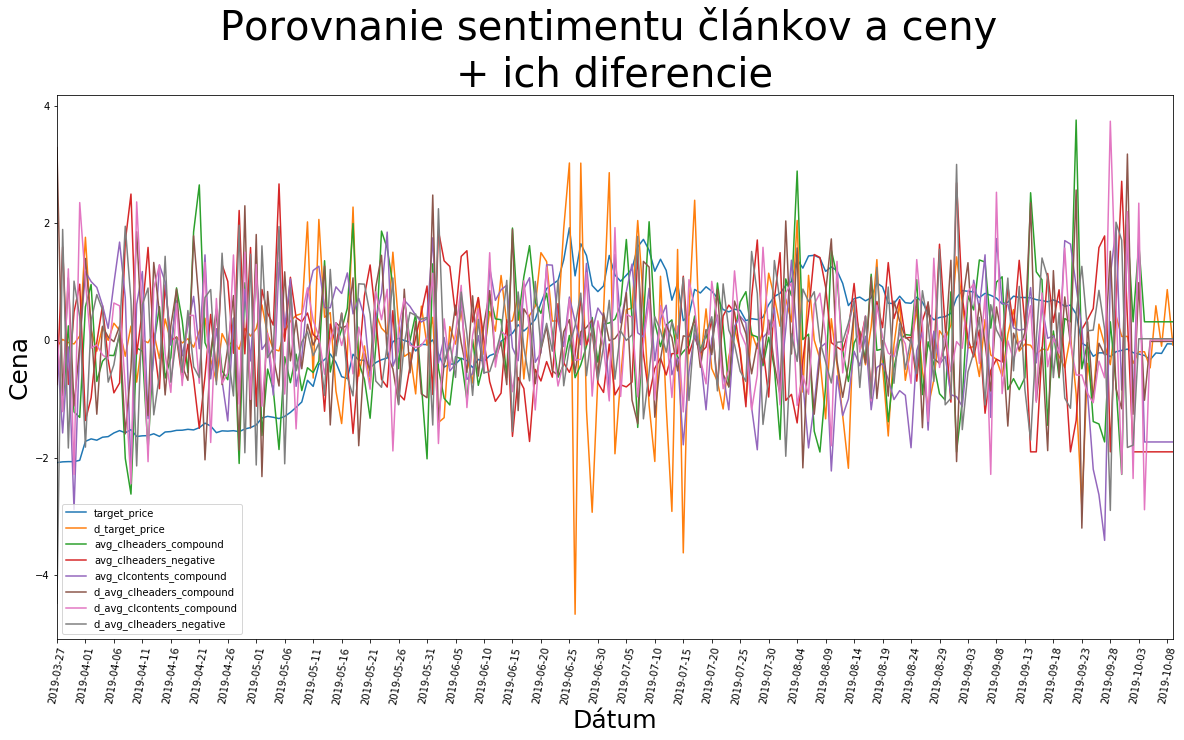

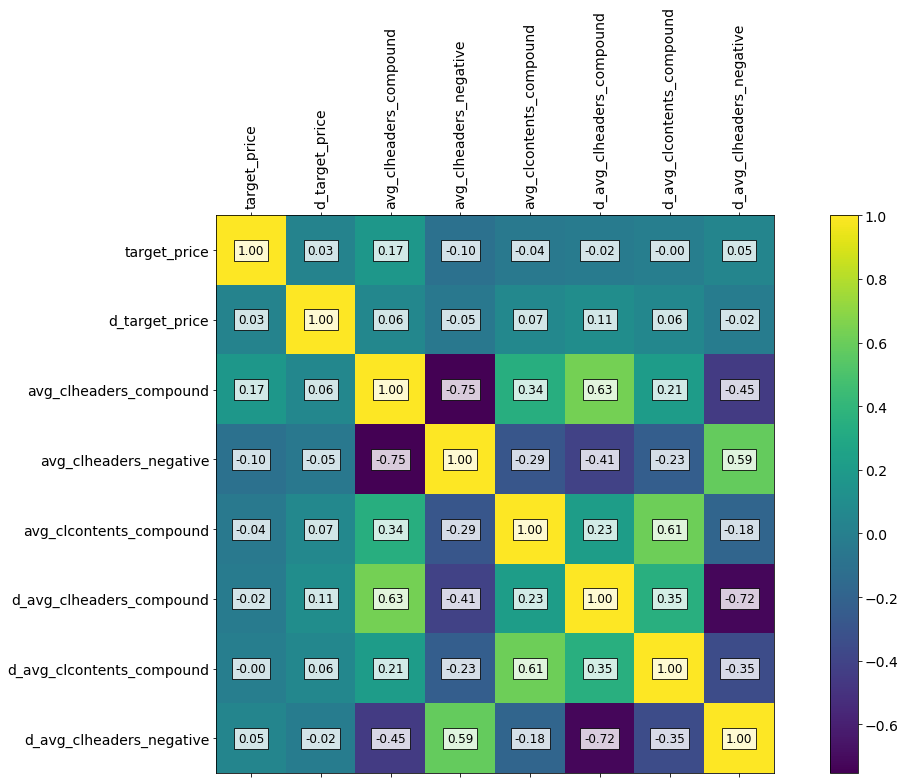

In [13]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'avg_clheaders_compound','avg_clheaders_negative', 'avg_clcontents_compound', 'd_avg_clheaders_compound', 'd_avg_clcontents_compound', 'd_avg_clheaders_negative'], scaler = StandardScaler(), title ='Porovnanie sentimentu článkov a ceny \n+ ich diferencie',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 12)
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.avg_clheaders_compound)))
print("Durbin-Watson test for avg_clcontents_compound autocorrelation:  " + str(AutocorrelationTest(dfc.avg_clcontents_compound)))
print("Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_clheaders_compound)))
print("Durbin-Watson test for d_avg_clcontents_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_avg_clcontents_compound)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Classification SECTION

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


In [26]:
def PrepareDataset():
    df = pd.read_csv("data.csv")
    dff = df[['date', 'close_price','avg_clheaders_compound','avg_clheaders_negative', 'avg_clcontents_compound']].copy()
    dff['target_price'] = dff['close_price'].shift(-1)
    dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
    #dff['d_price_move'] = dff.close_price - dff.open_price
    dff['d_avg_clheaders_negative'] = np.insert(np.diff(dff['avg_clheaders_negative']), 0, 0)
    dff['d_avg_clheaders_compound'] = np.insert(np.diff(dff['avg_clheaders_compound']), 0, 0)
    dff['d_avg_clcontents_compound'] = np.insert(np.diff(dff['avg_clcontents_compound']), 0, 0)
    
    dff = dff[:-1]
    dff = dff.iloc[1:]
    dff['target_rise_fall'] = (dff.d_target_price>0.0)
    return dff

def GetColumnSet(choice = None):
    if choice == 'compound':
        ret = ['target_rise_fall','tweet_volume','nonzero_compound_tweet','sum_compound_mul_follow','sum_compound','avg_sum_compound_mul_follow', 'd_tweet_volume','d_nonzero_compound_tweet','d_sum_compound_mul_follow','d_sum_compound','d_avg_sum_compound_mul_follow', 'my_feature1', 'my_feature2', 'my_feature3', 'my_feature4']
        msg = ret
    if choice is None:
        ret = None
        msg = 'ALL'
    print("Selected columns>> " + str(msg)+"\n\n")
    return ret

# Random Forrest whole set

In [77]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet())
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ALL


(197, 11)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.57      0.54      0.55        24
        True       0.56      0.58      0.57        24

    accuracy                           0.56        48
   macro avg       0.56      0.56      0.56        48
weighted avg       0.56      0.56      0.56        48

----------------Confusion_matrix--------------
[[13 11]
 [10 14]]
--------------------Accuracy------------------
0.5625


importance
d_avg_clheaders_negative     0.183322
close_price                  0.165654
avg_clheaders_negative       0.153846
d_avg_clheaders_compound     0.135549
d_avg_clcontents_compound    0.124297
avg_clcontents_compound      0.121188
avg_clheaders_compound       0.116144

# GaussianNB - whole dataset

In [73]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet())

Selected columns>> ALL


(197, 11)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.45      0.72      0.55        18
        True       0.74      0.47      0.57        30

    accuracy                           0.56        48
   macro avg       0.59      0.59      0.56        48
weighted avg       0.63      0.56      0.56        48

----------------Confusion_matrix--------------
[[13  5]
 [16 14]]
--------------------Accuracy------------------
0.5625


# SVM - whole dataset

Selected columns>> ALL


(197, 11)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.46      0.55      0.50        22
        True       0.55      0.46      0.50        26

    accuracy                           0.50        48
   macro avg       0.50      0.50      0.50        48
weighted avg       0.51      0.50      0.50        48

----------------Confusion_matrix--------------
[[12 10]
 [14 12]]
--------------------Accuracy------------------
0.5


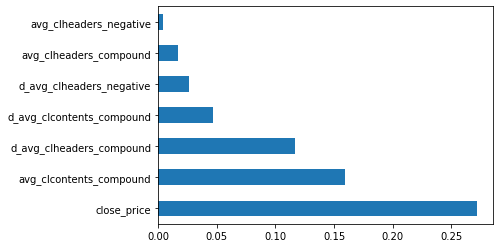

In [62]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet())
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

In [56]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet())

Selected columns>> ALL


(197, 11)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.42      0.76      0.54        17
        True       0.76      0.42      0.54        31

    accuracy                           0.54        48
   macro avg       0.59      0.59      0.54        48
weighted avg       0.64      0.54      0.54        48

----------------Confusion_matrix--------------
[[13  4]
 [18 13]]
--------------------Accuracy------------------
0.5416666666666666



# KNeighborsClassifier - whole dataset

In [47]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet())

Selected columns>> ALL


(197, 11)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.47      0.32      0.38        22
        True       0.55      0.69      0.61        26

    accuracy                           0.52        48
   macro avg       0.51      0.51      0.49        48
weighted avg       0.51      0.52      0.50        48

----------------Confusion_matrix--------------
[[ 7 15]
 [ 8 18]]
--------------------Accuracy------------------
0.5208333333333334


# Try for Votting classifiers

In [290]:
def Voting(df, columns = None, scaler = StandardScaler()):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    gnb = GaussianNB()
    rf = RandomForestClassifier(n_estimators=101)
    svml = svm.LinearSVC()
    svc = svm.SVC(gamma='scale')
    knb = KNeighborsClassifier(n_neighbors=5)
    
    gnb.fit(X_train, y_train.values.ravel())
    gnb_predict = gnb.predict(X_test)
    
    rf.fit(X_train, y_train.values.ravel())
    rf_predict = rf.predict(X_test)
    
    svml.fit(X_train, y_train.values.ravel())
    svm_predict = svml.predict(X_test)
    
    svc.fit(X_train, y_train.values.ravel())
    svc_predict = svc.predict(X_test)
    
    knb.fit(X_train, y_train.values.ravel())
    knb_predict = knb.predict(X_test)
    
    res = pd.DataFrame(gnb_predict, columns = ['gnb_predict']) 
    res['rf_predict'] = rf_predict
    res['svm_predict'] = svm_predict
    res['svc_predict'] = svc_predict
    res['knb_predict'] = knb_predict
    
    res['tftarget'] = np.array(y_test)
    return res

In [296]:
dff = PrepareDataset()
res = Voting(dff, columns = GetColumnSet(), scaler = StandardScaler())

Selected columns>> ALL


(197, 51)


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [297]:
res.head(5)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget
0         True        True         True         True         True     False
1         True       False         True         True        False      True
2         True       False         True         True        False     False
3         True       False        False        False        False     False
4         True       False        False        False         True     False

In [298]:
for index, row in res.iterrows():
    count = 0
    if row['gnb_predict'] == True:
        count +=1
    if row['rf_predict'] == True:
        count +=1
    if row['svm_predict'] == True:
        count +=1
    if row['svc_predict'] == True:
        count +=1
    if row['knb_predict'] == True:
        count +=1
    if count >=3:
        res.set_value(index, 'vote_res', True)
        count = 0
        continue
    res.set_value(index, 'vote_res', False)
    count = 0
    

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [299]:
res.head(50)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget  \
0          True        True         True         True         True     False   
1          True       False         True         True        False      True   
2          True       False         True         True        False     False   
3          True       False        False        False        False     False   
4          True       False        False        False         True     False   
5          True        True         True         True         True      True   
6          True        True         True         True        False     False   
7          True       False        False        False        False      True   
8          True        True        False         True         True      True   
9         False       False         True         True        False     False   
10         True        True         True         True         True      True   
11         True        True         True         True        False      True   
12         True        True         True         True        False      True   
13         True        True         True         True         True      True   
14        False        True        False         True         True     False   
15         True        True         True        False         True     False   
16         True       False         True        False         True      True   
17         True        True         True         True         True      True   
18         True        True        False         True         True      True   
19        False        True        False        False        False     False   
20         True       False         True         True        False      True   
21         True        True        False         True         True      True   
22         True        True        False         True         True     False   
23         True       False        False        False        False     False   
24         True        True        False        False        False     False   
25         True        True         True         True         True     False   
26         True        True         True         True        False     False   
27         True        True        False         True         True      True   
28         True        True        False         True        False     False   
29         True        True         True         True         True      True   
30         True        True         True         True        False      True   
31        False        True         True         True        False     False   
32         True       False        False         True        False     False   
33         True        True         True         True        False      True   
34        False        True         True         True         True     False   
35         True        True        False        False         True      True   
36         True       False         True         True        False     False   
37        False       False        False        False        False     False   
38         True        True         True         True         True      True   
39         True        True         True         True         True      True   
40         True       False        False        False        False      True   
41         True        True         True         True         True      True   
42        False       False        False         True         True      True   
43         True       False         True         True        False     False   
44         True        True        False         True        False     False   
45         True        True         True         True         True      True   
46         True        True        False         True        False     False   
47         True        True         True        False        False     False   

   vote_res  
0      True  
1      True  
2      True  
3     False  
4     False  

In [300]:

print("---------------------Summary------------------")
print(classification_report(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("----------------Confusion_matrix--------------")
print(confusion_matrix(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("--------------------Accuracy------------------")
print(accuracy_score(res.tftarget.values.tolist(), res.vote_res.values.tolist()))

---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.73      0.33      0.46        24
        True       0.57      0.88      0.69        24

    accuracy                           0.60        48
   macro avg       0.65      0.60      0.57        48
weighted avg       0.65      0.60      0.57        48

----------------Confusion_matrix--------------
[[ 8 16]
 [ 3 21]]
--------------------Accuracy------------------
0.6041666666666666
